# Lab08 - Regularization

* Created by: Mary Huibregtse,**adapted from a post by Aarshay Jain on Analytics Vidhya: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/** 
* Due Date: Tuesday, March 5 at 11:59 pm
* The data needed to complet this lab is titled _Auto.csv_ and is located in the canvas assignment and files

The goal of this worksheet is to help get familiar with the principles behind ridge and lasso regression. After completing this worksheet, you should be able to:

1) state the purpose of regularization techniques in general

2) identify the advantages of ridge and lasso over ordinary least squares

3) state scenarios in which you might prefer ridge over lasso and vice-versa

4) run these techniques on an example dataset using Python

**To recieve full credit for this assignment, complete all tasks and discussions**.

### Step 1: Set up simple Linear Regression

For our test data, let's create some points from a sine curve from 20 degrees to 320, and plot them just to be sure we have this correct.

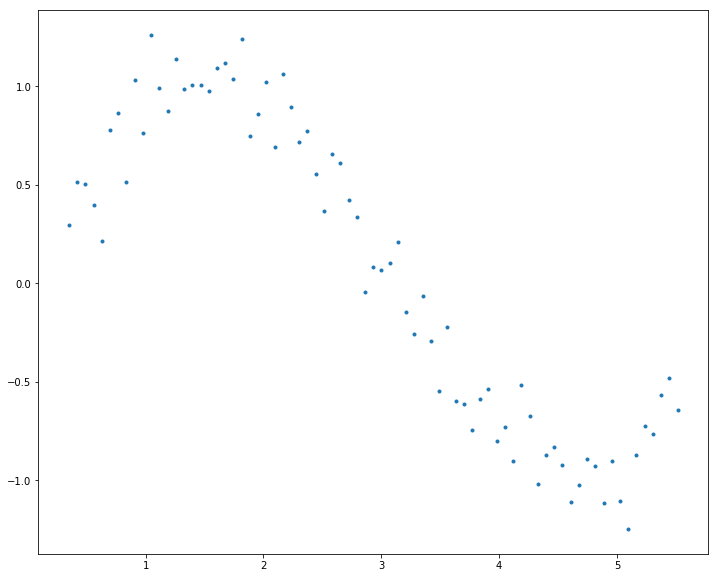

In [2]:
#Importing libraries. The same will be used throughout the notebook.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

#Define input array with angles from 20deg to 320deg converted to radians
x = np.array([i*np.pi/180 for i in range(20,320,4)])
np.random.seed(6)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

Now that we have this set, let's try fitting some models to it. Since we want to try a multivariate fit, let's create dummy imput variables by using powers of x: x^2, x^3, etc. These will allow us to create a regression on more than one variable.

In [2]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2       x_3       x_4       x_5       x_6  \
0  0.349066  0.295253  0.121847  0.042533  0.014847  0.005182  0.001809   
1  0.418879  0.516087  0.175460  0.073496  0.030786  0.012896  0.005402   
2  0.488692  0.502145  0.238820  0.116709  0.057035  0.027873  0.013621   
3  0.558505  0.395055  0.311928  0.174214  0.097299  0.054342  0.030350   
4  0.628319  0.214768  0.394784  0.248050  0.155855  0.097926  0.061529   

        x_7       x_8       x_9      x_10      x_11      x_12      x_13  \
0  0.000631  0.000220  0.000077  0.000027  0.000009  0.000003  0.000001   
1  0.002263  0.000948  0.000397  0.000166  0.000070  0.000029  0.000012   
2  0.006657  0.003253  0.001590  0.000777  0.000380  0.000186  0.000091   
3  0.016951  0.009467  0.005287  0.002953  0.001649  0.000921  0.000514   
4  0.038660  0.024291  0.015262  0.009590  0.006025  0.003786  0.002379   

           x_14          x_15  
0  3.987522e-07  1.391908e-07  
1  5.119653e-06  2.144515e-06  
2 

We're ready to run our test! This function will do all the hard work for us by fitting the model and plotting. Note that the power we input will also be the number of variables that we fit. So, using power=1 will result in a linear model using only x, while power=2 will be a polynomial model of the form alpha + beta_1 x + beta_2 x^2.

In [4]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression

#This function will 
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Great, that's set! Time to try it out on our data, and plot a few of them for increasing number of variables.

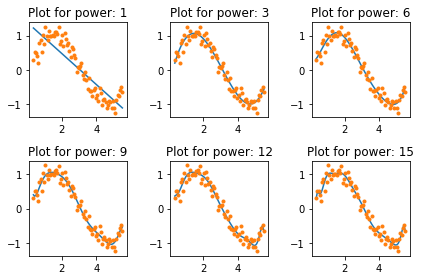

In [5]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate resulbts
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

### Discussion: 
* What power seems to be the best fit this data?
* which powers are over fitting? 
* Which powers are under fitting?

Please Insert your discussion here: 

As the power, or model complexity, increases, the models tends to fit even smaller deviations in the training data set. This also means that as power increases, the model tends to overfit. We start to see quite a bit of overfitting starting when power = 9. We see a severe case of underfitting when power = 1. We'll see that Lasso Regression adds penalty equivalent to absolute value of the magnitude of coefficients.


Now let's look at the coefficients in a table: 

In [5]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,10,1.4,-0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,9.3,1,-0.13,-0.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.7,-0.52,2.4,-1.1,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.7,-0.45,2.3,-0.98,0.089,0.0025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1.7,-0.34,1.9,-0.64,-0.055,0.029,-0.0018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,1.6,0.25,-0.43,2.5,-2,0.61,-0.087,0.0049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,1.6,0.064,0.44,1,-0.78,0.099,0.033,-0.0097,0.00071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,1.6,0.32,-0.99,4,-3.8,1.8,-0.53,0.098,-0.01,0.00047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,1.5,3.1,-18,45,-55,38,-16,4.4,-0.7,0.062,-0.0023,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,1.5,0.76,-2,0.43,11,-18,14,-6.5,1.7,-0.28,0.025,-0.00093,NaN,NaN,NaN,NaN,NaN


### Discussion: 
Our coefficients all seem to increase as we add more variables, when there is no "real" reason for them to do so. How might we combat this effect?

Insert your answer here:

To combat the effect that our coefficients increase as we add more variables, we should put a constraint on the magnitude of coefficients. A large coefficient means that we’re putting a lot of emphasis on the particular feature is a good predictor for the outcome. The algorithm starts modelling intricate relations to estimate the output and ends up overfitting.

### Section 2: Ridge Regression

Now we can define a function similar to the naive OLS fit we did above but using sklearn.linear_model.Ridge

In [6]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

Now we can run a similar test to what we did in step 1, but keeping all 15 variables (powers) and instead varying our lambda value

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.074822e-17
  overwrite_a=True).T


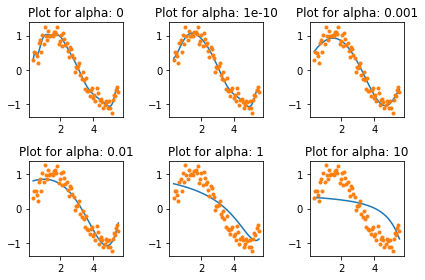

In [7]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [0, 1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {0:231, 1e-10:232, 1e-3:233, 1e-2:234, 1:235, 10:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Let's investigate how the coefficients change with varying values of alpha

In [8]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_0,1.4,-44,4.3e+02,-1.8e+03,4.3e+03,-6.5e+03,6.7e+03,-4.9e+03,2.6e+03,-1e+03,2.9e+02,-62,9.6,-1.1,0.077,-0.0034,6.7e-05
alpha_1e-15,1.5,2.3,-13,29,-29,11,1.3,-3.1,1.1,-0.1,-0.025,0.0045,0.00063,-0.00012,-2.1e-05,5.5e-06,-3.1e-07
alpha_1e-10,1.5,0.66,-2.7,6.8,-5.6,1.9,-0.15,-0.045,0.0018,0.0016,0.00018,-2.3e-05,-1.1e-05,-1.3e-06,2.4e-07,1e-07,-1.2e-08
alpha_1e-08,1.6,-0.2,1.5,-0.39,-0.088,0.046,-0.014,-0.0006,0.00069,0.00013,-5.2e-06,-6.4e-06,-1.2e-06,-1.4e-08,5.1e-08,1.1e-08,-2e-09
alpha_0.0001,1.7,-0.11,1.4,-0.41,-0.036,0.0023,0.0011,0.00019,2e-05,3.1e-07,-4.3e-07,-1.3e-07,-2.4e-08,-3.1e-09,-1.7e-10,6.3e-11,3e-11
alpha_0.001,2.2,0.29,0.8,-0.21,-0.027,-0.00099,0.00029,8.8e-05,1.5e-05,2e-06,1.8e-07,2.7e-09,-3.5e-09,-1e-09,-1.8e-10,-2.1e-11,2.9e-13
alpha_0.01,3.7,0.75,0.2,-0.075,-0.013,-0.0014,-6.6e-05,1.3e-05,5.2e-06,1.2e-06,2.1e-07,3.3e-08,4.3e-09,4.2e-10,1e-12,-1.4e-11,-5.4e-12
alpha_1,10,0.76,-0.1,-0.016,-0.0025,-0.00037,-5.2e-05,-6.7e-06,-7.8e-07,-7e-08,-1e-09,1.7e-09,6.1e-10,1.6e-10,3.7e-11,7.9e-12,1.6e-12
alpha_5,21,0.45,-0.045,-0.007,-0.0011,-0.00018,-2.9e-05,-4.4e-06,-6.7e-07,-1e-07,-1.5e-08,-2.1e-09,-2.8e-10,-3.5e-11,-3.8e-12,-2.5e-13,2.6e-14
alpha_10,26,0.34,-0.028,-0.0045,-0.00075,-0.00012,-2e-05,-3.3e-06,-5.4e-07,-8.7e-08,-1.4e-08,-2.3e-09,-3.6e-10,-5.8e-11,-9.1e-12,-1.4e-12,-2.2e-13


Check to see if any of the coefficients are 0

In [9]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_0         0
alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
dtype: int64

### Graph: 
Create a line graph, plotting coefficients vs. alpha

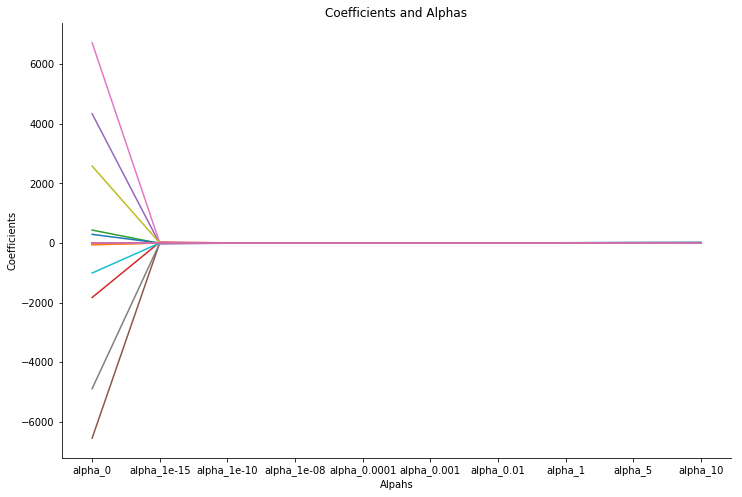

In [26]:
plt.figure(figsize=(12,8))
plt.title('Coefficients and Alphas')
plt.xlabel('Alpahs')
plt.ylabel('Coefficients')
ax = plt.plot(coef_matrix_ridge)
ax = plt.axes()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


### Discussion: 
* What do 0 coefficients mean? 
* How is this reflected in the graph?
* Give and example where _Ridge Regression_ would be a better choice than _Logistic_ or _Linear Regression_.

Please insert your answer here: 

When alpha = infinity, coefficient will be 0; because of infinite weightage on square of coefficients, anything less than 0 will make the objective infinite. The graph supports this because after a certain point, everything is zero indefinitely. The RSS increases with increase in alpha, this model complexity reduces and this can lead to significant underfitting. Ridge Regression is majorly used to **prevent overfitting**. Since it includes all the features, it is not very useful in case of exorbitantly high features, say in millions, as it will pose computational challenges.

### Section 3: Lasso (Least Absolute Shrinkage and Selection Operator)

Same as before, we start defining a generic function to help us out

In [27]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

Now we can plot different values of alpha

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


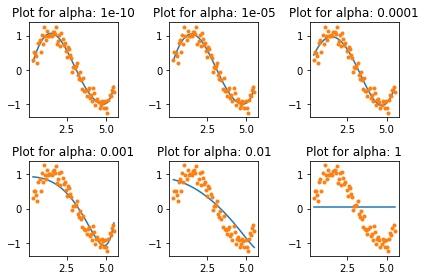

In [28]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

Looks like we serverly underfit when alpha = 1. Are any of the coefficients 0?

In [18]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,1.6,-0.36,1.9,-0.63,-0.037,0.012,0.0019,9.4e-05,-1.9e-05,-5.8e-06,-8.8e-07,-7.2e-08,4.2e-09,2.9e-09,6.1e-10,6e-11,-1.1e-11
alpha_1e-10,1.6,-0.36,1.9,-0.63,-0.037,0.012,0.0019,9.4e-05,-1.9e-05,-5.8e-06,-8.8e-07,-7.2e-08,4.2e-09,2.9e-09,6.1e-10,6e-11,-1.1e-11
alpha_1e-08,1.6,-0.36,1.9,-0.63,-0.037,0.012,0.0019,9.3e-05,-1.8e-05,-5.8e-06,-8.8e-07,-7.2e-08,4.1e-09,2.9e-09,6.1e-10,5.9e-11,-1.1e-11
alpha_1e-05,1.6,-0.29,1.8,-0.64,-0,0.003,0.0019,0,-0,-0,-1.2e-07,-2e-07,-0,-0,-0,0,1.9e-11
alpha_0.0001,1.9,0.053,1.2,-0.43,-0,0,0.0006,0.0001,0,0,0,-0,-0,-0,-0,-0,-3.9e-12
alpha_0.001,4.7,0.93,0,-0.04,-0.015,-0,-0,0,0,0,0,5.5e-08,6.3e-09,0,0,0,0
alpha_0.01,9.5,0.88,-0.076,-0.055,-0,-0,-0,0,0,0,0,0,0,0,0,0,6.9e-13
alpha_1,45,0.06,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,45,0.06,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,45,0.06,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


In [19]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      8
alpha_0.0001    10
alpha_0.001     11
alpha_0.01      12
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

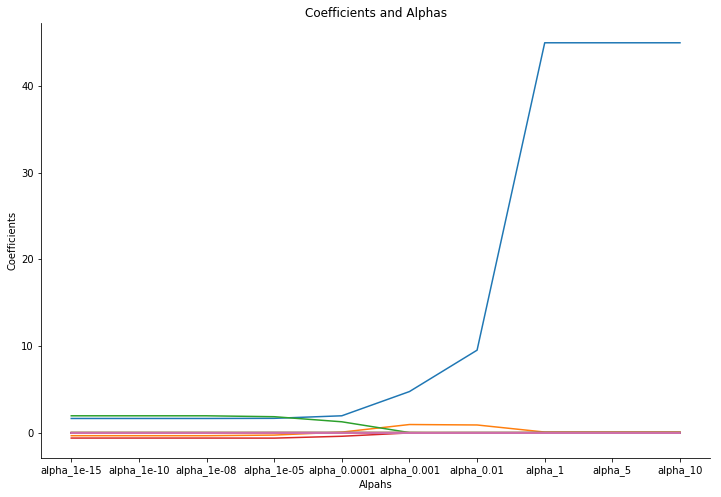

In [30]:
plt.figure(figsize=(12,8))
plt.title('Coefficients and Alphas')
plt.xlabel('Alpahs')
plt.ylabel('Coefficients')
ax = plt.plot(coef_matrix_lasso)
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Discussion: 
* How is _Lasso Regression_ different than _Ridge Regresion_?
* When is it best to use _Ridge? Lasso_?

Insert your answers here: 

For Lasso Regression, we can observe that even for a small value of alpha, a significant number of coefficients are zero, unlike Ridge Regression. This is called *sparsity*. Lasso sets less important predictors to zero and helps you with choosing the predictors that can be left out of the model. Ridge Regression is majorly used to prevent overfitting. Since it includes all the features, it is not very useful in case of exorbitantly high features, say in millions, as it will pose computational challenges. If you have highly correlated variables, Ridge is better because you're not penalizing one variable over another. This might also be subjective to your dataset, so both could work in different conditions.

### Step 4: Try it yourself!

Below you will find some code to load the auto data used in the splitting data lab. Use this data to try out OLS, Ridge, and Lasso for predicting MPG in terms of the other variables in the dataset. Compare the coefficients from each method to see what the difference is. Try varying your alpha value as well!

In [7]:
auto_data = pd.read_csv("Auto.csv")
auto_data = auto_data[auto_data.horsepower != '?'] #get rid of pesky "?" values

# response = "mpg" #identifies which variable we want to try to predict
# #predict based on all values other than name, since it is non-numeric
# #feel free to change this to any subset that you want to use to predict!
predictors = ['cylinders','displacement','horsepower','weight','acceleration','year','origin']

auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [14]:
#Run a OLS linear regression
linreg = LinearRegression(normalize=True)
linreg.fit(auto_data[predictors],auto_data['mpg'])
pred = linreg.predict(auto_data[predictors])

In [15]:
#Show OLS linear coefficients
linreg_coefs = pd.DataFrame(linreg.coef_)
linreg_coefs.index = predictors
linreg_coefs

,0
cylinders,-0.493376
displacement,0.019896
horsepower,-0.016951
weight,-0.006474
acceleration,0.080576
year,0.750773
origin,1.426140


In [18]:
#Run a Ridge regression
coefs = {}
alpha_ridge = [0, 1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
for alpha in alpha_ridge:
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(auto_data[predictors],auto_data['mpg'])
    pred = ridgereg.predict(auto_data[predictors])
    coefs[alpha] = ridgereg.coef_

In [19]:
#Show Ridge coefficients
ridge_coefs = pd.DataFrame(coefs)
ridge_coefs.index = predictors
ridge_coefs

,0.0,1e-15,1e-10,1e-08,0.0001,0.001,0.01,1.0,5.0,10.0,20.0
cylinders,-0.493376,-0.493376,-0.493376,-0.493376,-0.491990,-0.480068,-0.401494,-0.569294,-0.361495,-0.240582,-0.143688
displacement,0.019896,0.019896,0.019896,0.019896,0.019807,0.019033,0.012988,-0.009554,-0.006101,-0.004061,-0.002425
horsepower,-0.016951,-0.016951,-0.016951,-0.016951,-0.016980,-0.017239,-0.019626,-0.026722,-0.016149,-0.010705,-0.006383
weight,-0.006474,-0.006474,-0.006474,-0.006474,-0.006466,-0.006394,-0.005788,-0.001652,-0.000833,-0.000536,-0.000314
acceleration,0.080576,0.080576,0.080576,0.080576,0.080055,0.075473,0.038042,0.072449,0.100073,0.073380,0.046029
year,0.750773,0.750773,0.750773,0.750773,0.750583,0.748894,0.733844,0.373902,0.155609,0.093920,0.052976
origin,1.426140,1.426140,1.426140,1.426140,1.425548,1.420387,1.381652,1.032221,0.581177,0.378894,0.223788


In [21]:
#Run a Lasso regression
coefs = {}
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
#Fit the model
for alpha in alpha_lasso:
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(auto_data[predictors],auto_data['mpg'])
    pred = lassoreg.predict(auto_data[predictors])
    coefs[alpha] = lassoreg.coef_

In [22]:
#Show Lasso coefficients
lasso_coefs = pd.DataFrame(coefs)
lasso_coefs.index = predictors
lasso_coefs

,1e-15,1e-10,1e-08,1e-05,0.0001,0.001,0.01,1.0,5.0,10.0
cylinders,-0.493376,-0.493376,-0.493374,-0.490905,-0.469247,-0.253338,-0.000000,-0.0,-0.0,-0.0
displacement,0.019896,0.019896,0.019896,0.019809,0.019032,0.011339,-0.000000,-0.0,-0.0,-0.0
horsepower,-0.016951,-0.016951,-0.016951,-0.016911,-0.016545,-0.012891,-0.009344,-0.0,-0.0,-0.0
weight,-0.006474,-0.006474,-0.006474,-0.006471,-0.006442,-0.006160,-0.005538,-0.0,-0.0,-0.0
acceleration,0.080576,0.080576,0.080576,0.080382,0.078623,0.061492,0.000000,0.0,0.0,0.0
year,0.750773,0.750773,0.750773,0.750692,0.749957,0.742724,0.699938,0.0,0.0,0.0
origin,1.426140,1.426140,1.426139,1.424982,1.414471,1.310448,1.029730,0.0,0.0,0.0


#### Which predictors did Lasso select (non-zero coefficients)? Does this match your intuition for which predictors are the most significant?

Lasso selected all of them to a point, and then only included horsepower, weight, year, and origin right before not including any of them as alpha increases. I think this matches my intuition? I don't know much about cars :/

### Step 5: Reflection

#### Overall, which of the three methods did you find to be the best fit for the data you investigated (OLS, Ridge, Lasso)? Explain your answer, and be sure to discuss what specific strengths this approach has.

I think Lasso might be the best fit for the data investigated. We don't really need Ridge because the advantage of Ridge Regression is to avoid overfitting by adding a penalty to models that have too large coefficients. In our data, we do not have very large coefficients.